# BMW Inventory

## Introduction

BMW employs an advanced inventory management system known as ALOIS (Automated Logistic Information System). This sophisticated system is specifically designed to streamline and optimize the logistics and supply chain operations within BMW. ALOIS integrates various facets of inventory management, including real-time tracking, automated data collection, demand forecasting, and efficient supplier coordination. By leveraging these capabilities, BMW can maintain optimal inventory levels, reduce costs, and enhance overall supply chain efficiency.

This notebook provides an analysis of the inventory status at a specific point in time. While it captures a snapshot of the inventory, it does not encompass sufficient data to estimate or identify demand trends over time. However, based on the key performance indicators (KPIs) utilized by the agency, it appears that they can effectively use these metrics to establish a proportionate inventory policy and estimate optimal inventory levels and strategies. The agency also tracks critical metrics such as the fill rate and inventory turnover ratio, although this dataset does not include all transactions required to compute these statistics accurately.

Despite the robust framework in place, the current analysis suggests that the inventory management system might not be functioning as designed. No specific cause for this discrepancy has been identified thus far.

## Cleannig data

The team members obtained the inventory database as of March 27, 2025. The information is contained in the file 'Stock BMW.xlsx.' The file includes three sheets. The sheet "Líneas con stock" reports the inventory records available at that time. The sheet "Part group", added later, includes a description of the type of item. The final sheet "Leyenda" provides a detailed description of the relevant variables in the database.

To clean the data, we performed the following steps:
* Read all columns as text initially, and then converted the appropriate ones to numeric values. This was necessary since item references could be interpreted as either strings or numbers.
* Ensured that only items with available stock were included in the dataset.
* Verified that there were no duplicate item references.
* Checked that all item references were 11 characters long. Only one item failed this check, and it was corrected manually in the Excel file.
* Used the first two characters of the item reference to determine the item group and provide a practical description. Group 39 still needs a description, as there was no information available online for this group.
* Created two new columns: one for the order type (A, L, O, S) and another for demand frequency (1, 2, ...).
* Calculated the overstock by subtracting 'Obj. Planif.' from 'Stock'."
* Calculated the Annual consumption value as annual demand "Pick 12 annual" times Costo Unitario.

In [55]:
# Open excel file and read sheet "Líneas con stock Total". Start in row 17
import pandas as pd

df = pd.read_excel(
    "Stock BMW.xlsx",
    sheet_name="Líneas con stock",
    header=16,
    dtype=str
)
df.head(3)

,Ref.,Descr.,Descr. Adic.,SA-Pick,Vtas 12 mes actual no efect.,Vtas 12 mes actual efect.,Pick 12 actual,COSTO UNITARIO,Ventas a coste 12,Stock,IMPORTE,Pto. de Ped.,Obj. Planif.,Cant. Pdte. Recib.,TA,Ubic.
0,83190404517,Junta líqui,50ML,L4,0,28,26,482.3,11457.88,1,482.3,1,3,0,9,A6-C
1,01405A53BF7,Manual instr,es,OA,0,0,0,668.55,0,2,1337.1,0,0,0,4,K3
2,07119900439,TORNILLO COR,CM4X10,SZ,0,0,0,2.2,0,3,6.6,0,0,0,1,I11-MOT


In [56]:
# Read sheet "Part group"
df_part_group = pd.read_excel(
    "Stock BMW.xlsx",
    sheet_name="Part group",
    header=0,
    dtype=str
)
df_part_group.head()

,Group,Description
0,01,Technical Literature
1,02,Scopes of Service and repair work
2,07,"Generic parts (lubricants, fasteners, cable etc.)"
3,11,Engine Mechanical
4,12,Engine Electrical


In [57]:
# Define non-numeric columns
non_numeric_columns = ["Ref.", "Descr.", "Descr. Adic.", "SA-Pick", "Ubic."]
# Convert the other columns to numeric, forcing errors to NaN
for col in df.columns:
    if col not in non_numeric_columns:
        df[col] = pd.to_numeric(df[col], errors="coerce") 

In [58]:
# Filter the dataframe to only include rows where "Stock Total" is equal to 0
df_zero_stock = df[df["Stock"] == 0]
df_zero_stock = df_zero_stock[["Ref.", "Descr.", "Stock", "IMPORTE"]]
df_zero_stock.sort_values(by="IMPORTE", ascending=False)

,Ref.,Descr.,Stock,IMPORTE


In [59]:
# Verify that Ref. is unique and print the non-unique references
non_unique_references = df[df["Ref."].duplicated(keep=False)]
print("Non-unique references:")
print(non_unique_references[["Ref.", "Descr.", "Stock", "IMPORTE"]])

Non-unique references:
Empty DataFrame
Columns: [Ref., Descr., Stock, IMPORTE]
Index: []


In [60]:
# Verify that Ref. has 11 characters
def check_ref_length(ref):
    return len(ref) == 11

df["Ref. Length Check"] = df["Ref."].apply(check_ref_length)
# Print the rows where Ref. length is not 11
invalid_ref_length = df[~df["Ref. Length Check"]]
print("Invalid Ref. Length:")
invalid_ref_length[["Ref.", "Descr.", "Stock", "IMPORTE"]]

Invalid Ref. Length:


,Ref.,Descr.,Stock,IMPORTE


In [61]:
# Extract first 2 characters of Ref. and create a new column
df["Group"] = df["Ref."].str[:2]
# Identify "Group" codes that are not in the "Part group" sheet
invalid_groups = df[~df["Group"].isin(df_part_group["Group"])]
print("Invalid Groups:")
invalid_groups[["Ref.", "Descr.", "Stock", "IMPORTE", "Group"]]

Invalid Groups:


,Ref.,Descr.,Stock,IMPORTE,Group


In [62]:
# For each code in "Group" look for "Description" in df_part_group and add it to df.
df = df.merge(df_part_group, on="Group", how="left")
# Rename columns
df.rename(columns={"Description": "Group Description"}, inplace=True)
df.head(3)

,Ref.,Descr.,Descr. Adic.,SA-Pick,Vtas 12 mes actual no efect.,Vtas 12 mes actual efect.,Pick 12 actual,COSTO UNITARIO,Ventas a coste 12,Stock,IMPORTE,Pto. de Ped.,Obj. Planif.,Cant. Pdte. Recib.,TA,Ubic.,Ref. Length Check,Group,Group Description
0,83190404517,Junta líqui,50ML,L4,0,28.0,26,482.30,11457.88,1.0,482.3,1,3,0,9,A6-C,True,83,Car care products
1,01405A53BF7,Manual instr,es,OA,0,0.0,0,668.55,0.00,2.0,1337.1,0,0,0,4,K3,True,01,Technical Literature
2,07119900439,TORNILLO COR,CM4X10,SZ,0,0.0,0,2.20,0.00,3.0,6.6,0,0,0,1,I11-MOT,True,07,"Generic parts (lubricants, fasteners, cable etc.)"


In [63]:
# Use "SA-Pick" to make two new columns. First character is denotes Order Type and the second character denotes Demand Frequency.
df["Order Type"] = df["SA-Pick"].str[0]
df["Demand Frequency"] = df["SA-Pick"].str[1]
df.head(3)

,Ref.,Descr.,Descr. Adic.,SA-Pick,Vtas 12 mes actual no efect.,Vtas 12 mes actual efect.,Pick 12 actual,COSTO UNITARIO,Ventas a coste 12,Stock,...,Pto. de Ped.,Obj. Planif.,Cant. Pdte. Recib.,TA,Ubic.,Ref. Length Check,Group,Group Description,Order Type,Demand Frequency
0,83190404517,Junta líqui,50ML,L4,0,28.0,26,482.30,11457.88,1.0,...,1,3,0,9,A6-C,True,83,Car care products,L,4
1,01405A53BF7,Manual instr,es,OA,0,0.0,0,668.55,0.00,2.0,...,0,0,0,4,K3,True,01,Technical Literature,O,A
2,07119900439,TORNILLO COR,CM4X10,SZ,0,0.0,0,2.20,0.00,3.0,...,0,0,0,1,I11-MOT,True,07,"Generic parts (lubricants, fasteners, cable etc.)",S,Z


In [64]:
# Compute Overstock as "Stock" + "Cant. Pdte. Recib." - "Obj. Pdte. Recib."
df["Overstock"] = df["Stock"] - df["Obj. Planif."]
# Set negative Overstock values to 0
df["Overstock"] = df["Overstock"].where(df["Overstock"] > 0, 0)
# Compute "Overinventory" as "Overstock" * "IMPORTE" where "Overstock" is greater than 0
df["Overinventory"] = df["Overstock"]* df["COSTO UNITARIO"]
df.head(3)

,Ref.,Descr.,Descr. Adic.,SA-Pick,Vtas 12 mes actual no efect.,Vtas 12 mes actual efect.,Pick 12 actual,COSTO UNITARIO,Ventas a coste 12,Stock,...,Cant. Pdte. Recib.,TA,Ubic.,Ref. Length Check,Group,Group Description,Order Type,Demand Frequency,Overstock,Overinventory
0,83190404517,Junta líqui,50ML,L4,0,28.0,26,482.30,11457.88,1.0,...,0,9,A6-C,True,83,Car care products,L,4,0.0,0.0
1,01405A53BF7,Manual instr,es,OA,0,0.0,0,668.55,0.00,2.0,...,0,4,K3,True,01,Technical Literature,O,A,2.0,1337.1
2,07119900439,TORNILLO COR,CM4X10,SZ,0,0.0,0,2.20,0.00,3.0,...,0,1,I11-MOT,True,07,"Generic parts (lubricants, fasteners, cable etc.)",S,Z,3.0,6.6


In [65]:
# Compute Annual consumpiton value as "Pick 12 actual" * "COSTO UNITARIO"
df["Annual Consumption Value"] = df["Pick 12 actual"] * df["COSTO UNITARIO"]
df.head(3)

,Ref.,Descr.,Descr. Adic.,SA-Pick,Vtas 12 mes actual no efect.,Vtas 12 mes actual efect.,Pick 12 actual,COSTO UNITARIO,Ventas a coste 12,Stock,...,TA,Ubic.,Ref. Length Check,Group,Group Description,Order Type,Demand Frequency,Overstock,Overinventory,Annual Consumption Value
0,83190404517,Junta líqui,50ML,L4,0,28.0,26,482.30,11457.88,1.0,...,9,A6-C,True,83,Car care products,L,4,0.0,0.0,12539.8
1,01405A53BF7,Manual instr,es,OA,0,0.0,0,668.55,0.00,2.0,...,4,K3,True,01,Technical Literature,O,A,2.0,1337.1,0.0
2,07119900439,TORNILLO COR,CM4X10,SZ,0,0.0,0,2.20,0.00,3.0,...,1,I11-MOT,True,07,"Generic parts (lubricants, fasteners, cable etc.)",S,Z,3.0,6.6,0.0


## Inconsistencias

We identified instances where the data format was correct, but the values were inconsistent in specific contexts. The inconsistencies discovered are as follows:
* Three records contain fractional stock values, which are not feasible for the items in question.
* There are instances where stock is arriving despite the objective being to not order this product.

In [66]:
# List rows where "Stock" is not a whole number (i.e., has a fractional part)
non_integer_stocks = df[df["Stock"] % 1 != 0]
print("Stocks with fractional values:")
print(non_integer_stocks[["Ref.", "Descr.", "Stock", "IMPORTE"]])
# Round the "Stock" to the nearest integer
# df["Stock"] = df["Stock"].round().astype(int)

Stocks with fractional values:
             Ref.       Descr.  Stock    IMPORTE
2217  83222413511  Hypoid Axle    5.8   4312.416
2219  83222447362  Hypoid Axle   26.2  19838.378
2222  83225A4F016        Dtf 1    4.3   3149.320


In [67]:
# List rows where "Obj. Planif." is zero, but "Cant. Pdte. Recib." is non-zero
non_zero_obj_planif = df[(df["Obj. Planif."] == 0) & (df["Cant. Pdte. Recib."] != 0)]
print("Obj. Planif. is zero but Cant. Pdte. Recib. is non-zero:")
non_zero_obj_planif[["Ref.", "Descr.", "SA-Pick", "Stock", "Obj. Planif.", "Cant. Pdte. Recib."]].sort_values(by="SA-Pick") 

Obj. Planif. is zero but Cant. Pdte. Recib. is non-zero:


,Ref.,Descr.,SA-Pick,Stock,Obj. Planif.,Cant. Pdte. Recib.
465,34106891079,Disco de fre,O8,8.0,0,8
654,36122461754,Pirelli P-Ze,O8,1.0,0,1
12,07119905176,TORNILLO HUE,OA,2.0,0,2
30,07119963253,Anillo obtur,OA,3.0,0,4
128,11658691853,Juego regula,OA,1.0,0,1
126,11657534454,Tuberia acei,OV,1.0,0,1
1150,51357491331,Listón d ad,OV,1.0,0,1
1298,51717354217,Cubierta der,OV,1.0,0,1
267,22117581620,Soporte del,SZ,1.0,0,1
752,51115A39374,Embellecedor,SZ,1.0,0,1


## Main statistics

The agency already manage many indicators to visualize the status of its inventory. Some of these key indicator that we can also compute are "Valor total stock" (8,838,925 MXN), "Ratio de exceso del stock surtido A" (28.62%), "Ratio de exceso del stock surtido L" (35.5%) y "Porcentaje del surtido O sobre valor total stock" (61.12%). To compute these indicators for this dataset and have a more complete computation of all order types, we constructed the following table. This table shows similar results than the ones reported by the agency.

In [68]:
def count_gt_zero(x):
    return (x > 0).sum()

def percent_of_importe(x):
    importe_sum = df.loc[x.index, "IMPORTE"].sum()
    return (x.sum() / importe_sum * 100) if importe_sum > 0 else 0

def percent_of_value(x):
    return (x.sum() / df.IMPORTE.sum() * 100)

dfsurplus = (
    df.pivot_table(
        index="Order Type",
        values=["Ref.", "Stock", "IMPORTE", "Overstock", "Overinventory"],
        aggfunc={
            "Ref.": "nunique",
            "Stock": "sum",
            "IMPORTE": ["sum", percent_of_value],
            "Overstock": [count_gt_zero, "sum"],
            "Overinventory": ["sum", percent_of_importe]
        }
    )
)

dfsurplus = dfsurplus[
    [
        ("Ref.", "nunique"),
        ("Stock", "sum"),
        ("IMPORTE", "sum"),
        ("IMPORTE", "percent_of_value"),
        ("Overstock", "count_gt_zero"),
        ("Overstock", "sum"),      
        ("Overinventory", "sum"),
        ("Overinventory", "percent_of_importe")
    ]
]

dfsurplus.columns = [
    "Items",
    "Stock",
    "Value",
    "% of total value",
    "Surplus items",
    "Surplus stock",
    "Surplus value",
    "% Surplus value"
]

dfsurplus["Stock"] = dfsurplus["Stock"].astype(int)
dfsurplus["Value"] = dfsurplus["Value"].map(lambda x: f"${x:,.2f}")
dfsurplus["% of total value"] = dfsurplus["% of total value"].map(lambda x: f"{x:.2f}%")
dfsurplus["Surplus stock"] = dfsurplus["Surplus stock"].astype(int)
dfsurplus["Surplus value"] = dfsurplus["Surplus value"].map(lambda x: f"${x:,.2f}")
dfsurplus["% Surplus value"] = dfsurplus["% Surplus value"].map(lambda x: f"{x:.2f}%")
dfsurplus

,Items,Stock,Value,% of total value,Surplus items,Surplus stock,Surplus value,% Surplus value
Order Type,,,,,,,,
A,191,1256,"$925,700.49",10.88%,94,389,"$307,775.93",33.25%
L,136,674,"$658,336.32",7.74%,55,202,"$246,567.35",37.45%
O,1336,2799,"$5,190,770.96",61.03%,1336,2799,"$5,190,770.96",100.00%
S,570,1089,"$1,730,716.98",20.35%,568,1086,"$1,701,711.73",98.32%


## Multi-criteria inventory

Multi-criteria inventory management involves considering multiple factors or criteria to evaluate and categorize inventory items. The agency inventory utilizes two key criteria to manage its stock effectively: the type of order and the frequency of demand.


In [69]:
order_types = df["Order Type"].unique()
criteria_OrderType = {}

for ot in order_types:
    df_ot = df[df["Order Type"] == ot]
    item_counts = df_ot["Demand Frequency"].value_counts().sort_index()
    total_items = item_counts.sum()
    annual_consumption = df_ot.groupby("Demand Frequency")["Annual Consumption Value"].sum()
    total_annual_consumption = annual_consumption.sum()
    summary_df = pd.DataFrame({
        "Item Count": item_counts,
        "% of Items": (item_counts / total_items * 100).round(2),
        "Annual Consumption Value": annual_consumption,
        "% of Annual Consumption": (annual_consumption / total_annual_consumption * 100).round(2)
    })
    summary_df.reset_index(inplace=True)
    summary_df.rename(columns={"index": "Demand Frequency"}, inplace=True)
    criteria_OrderType[ot] = summary_df


In [70]:
criteria_OrderType['A']

,Demand Frequency,Item Count,% of Items,Annual Consumption Value,% of Annual Consumption
0,1,3,1.57,838652.72,11.60
1,2,12,6.28,1319071.34,18.25
2,3,10,5.24,646735.88,8.95
3,4,56,29.32,2469245.61,34.17
4,5,48,25.13,1163767.29,16.10
5,6,62,32.46,789771.73,10.93


In [71]:
criteria_OrderType['L']

,Demand Frequency,Item Count,% of Items,Annual Consumption Value,% of Annual Consumption
0,1,1,0.74,101006.10,3.41
1,2,4,2.94,117856.94,3.98
2,3,4,2.94,271705.46,9.16
3,4,7,5.15,651154.43,21.96
4,5,9,6.62,221900.19,7.48
5,6,34,25.00,853456.33,28.78
6,7,77,56.62,747861.36,25.22


In [72]:
criteria_OrderType['O']

,Demand Frequency,Item Count,% of Items,Annual Consumption Value,% of Annual Consumption
0,8,449,33.61,1835696.72,67.15
1,A,420,31.44,0.00,0.00
2,E,28,2.10,898215.41,32.85
3,N,162,12.13,0.00,0.00
4,V,277,20.73,0.00,0.00


In [73]:
criteria_OrderType['S']

,Demand Frequency,Item Count,% of Items,Annual Consumption Value,% of Annual Consumption
0,C,36,6.32,110362.70,19.32
1,E,7,1.23,0.00,0.00
2,K,36,6.32,394776.84,69.12
3,Z,491,86.14,66008.42,11.56


In [74]:
# Merge the four dataframes for each order type into a single dataframe, adding a column for order type
df_all = []
for ot in criteria_OrderType:
    df_temp = criteria_OrderType[ot].copy()
    df_temp["Order Type"] = ot
    # Move "Order Type" to the first column
    cols = ["Order Type"] + [col for col in df_temp.columns if col != "Order Type"]
    df_temp = df_temp[cols]
    df_all.append(df_temp)
df_OrderType = pd.concat(df_all, ignore_index=True)
df_OrderType

,Order Type,Demand Frequency,Item Count,% of Items,Annual Consumption Value,% of Annual Consumption
0,L,1,1,0.74,101006.10,3.41
1,L,2,4,2.94,117856.94,3.98
2,L,3,4,2.94,271705.46,9.16
3,L,4,7,5.15,651154.43,21.96
4,L,5,9,6.62,221900.19,7.48
5,L,6,34,25.00,853456.33,28.78
6,L,7,77,56.62,747861.36,25.22
7,O,8,449,33.61,1835696.72,67.15
8,O,A,420,31.44,0.00,0.00
9,O,E,28,2.10,898215.41,32.85


## Group Part

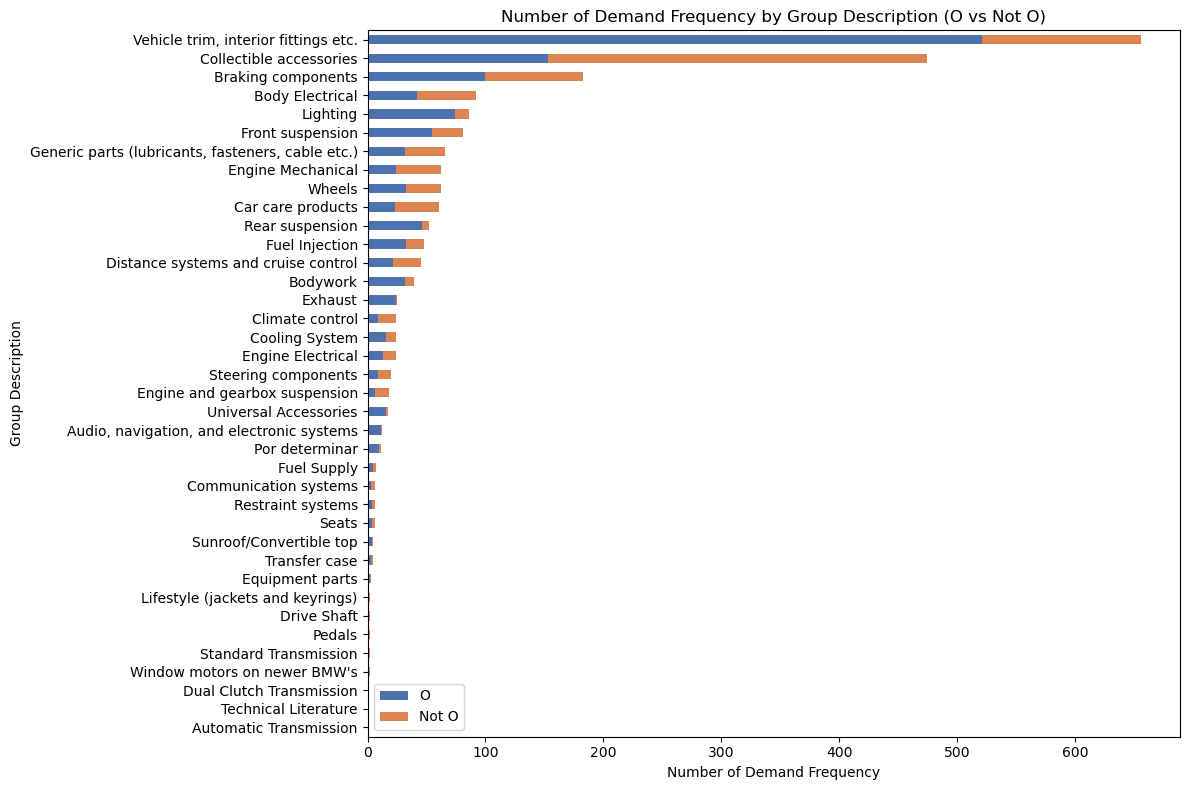

In [75]:
# Prepare data for stacked barplot: IMPORTE by Group Description, split by Demand Variability "O" and not "O"
import matplotlib.pyplot as plt
import seaborn as sns

pivot = df.pivot_table(
    index="Group Description",
    columns=df["Order Type"] == "O",
    values="Demand Frequency",
    aggfunc="count",
    fill_value=0
)
pivot.columns = ["Not O", "O"]
pivot = pivot.loc[pivot.sum(axis=1).sort_values(ascending=True).index]

plt.figure(figsize=(12, 8))
pivot[["O", "Not O"]].plot(
    kind="barh",
    stacked=True,
    color=["#4C72B0", "#DD8452"],
    ax=plt.gca()
)
plt.title('Number of Demand Frequency by Group Description (O vs Not O)')
plt.xlabel("Number of Demand Frequency")
plt.ylabel("Group Description")
plt.tight_layout()
plt.show()


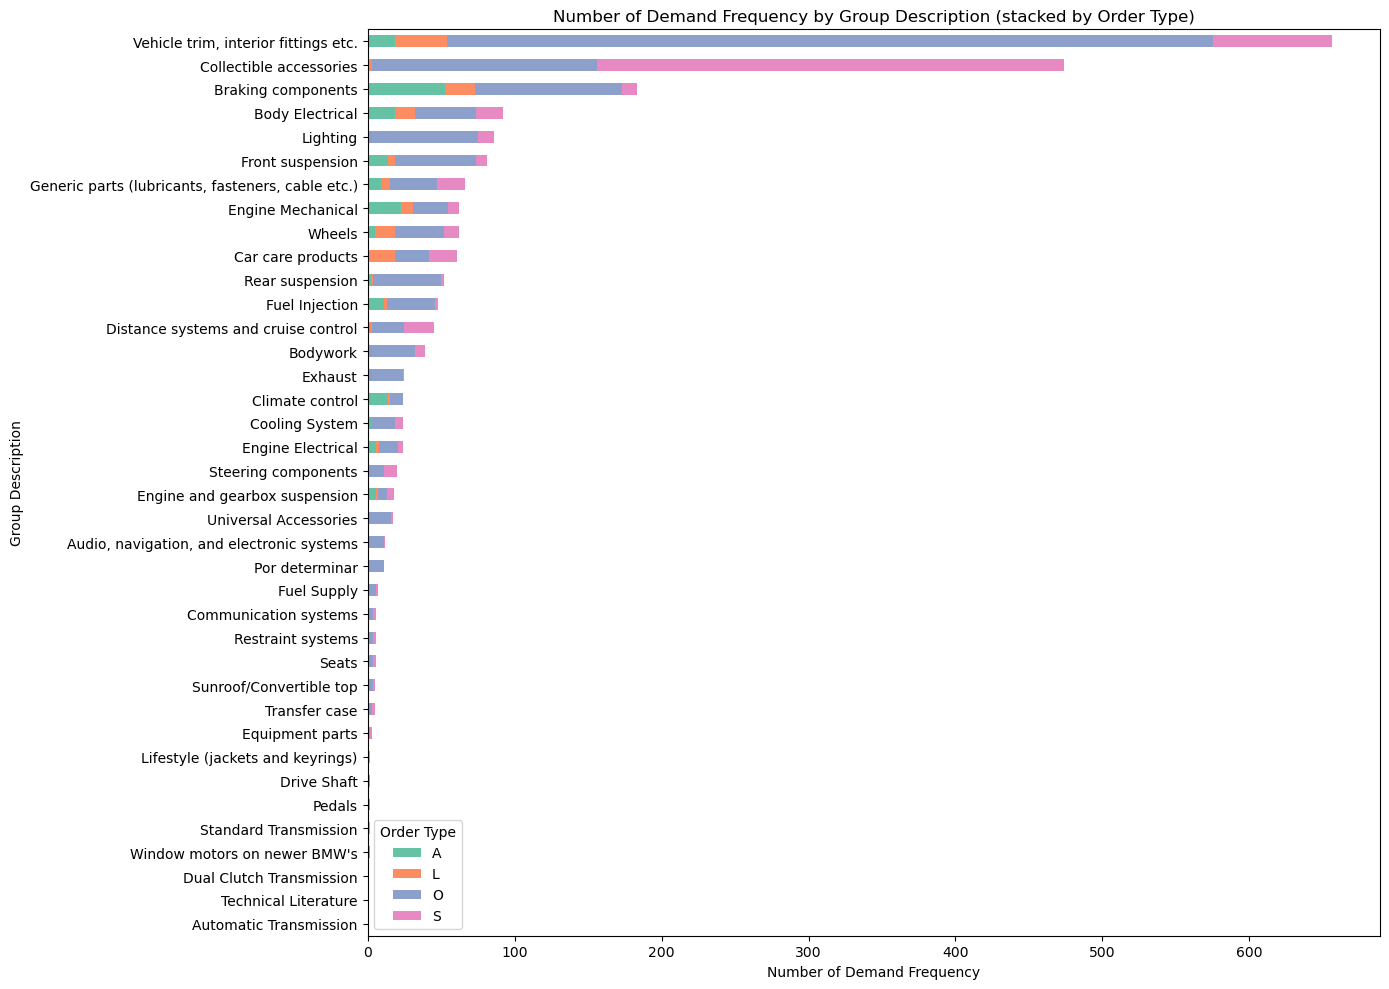

In [76]:
# Barplot: Number of Demand Frequency by Group Description, stacked by Order Type (A, L, O, S)
pivot_ot = df.pivot_table(
    index="Group Description",
    columns="Order Type",
    values="Demand Frequency",
    aggfunc="count",
    fill_value=0
)
# Ensure columns are in the desired order
order = ["A", "L", "O", "S"]
pivot_ot = pivot_ot[order]
pivot_ot = pivot_ot.loc[pivot_ot.sum(axis=1).sort_values(ascending=True).index]

plt.figure(figsize=(14, 10))
pivot_ot.plot(
    kind="barh",
    stacked=True,
    color=sns.color_palette("Set2", n_colors=4),
    ax=plt.gca()
)
plt.title('Number of Demand Frequency by Group Description (stacked by Order Type)')
plt.xlabel("Number of Demand Frequency")
plt.ylabel("Group Description")
plt.tight_layout()
plt.show()

## Overinventory

In [77]:
# Construct dataframe to compute at a column overstock and overinventory. Group by "SA Pick".
df_grouped = df.groupby("SA-Pick").agg(
    {
        "Stock": "sum",
        "Cant. Pdte. Recib.": "sum",
        "IMPORTE": "sum",
        "Overstock": "sum",
        "Overinventory": "sum"
    }
)
# Format columns as requested
df_grouped_display = df_grouped.copy()
df_grouped_display["Stock"] = df_grouped_display["Stock"].round(0).astype(int)
df_grouped_display["Overstock"] = df_grouped_display["Overstock"].round(0).astype(int)
df_grouped_display["IMPORTE"] = df_grouped_display["IMPORTE"].round(2)
df_grouped_display["Overinventory"] = df_grouped_display["Overinventory"].round(2)
df_grouped_display


,Stock,Cant. Pdte. Recib.,IMPORTE,Overstock,Overinventory
SA-Pick,,,,,
A1,83,0,52180.82,0,0.00
A2,235,50,115121.84,7,7246.35
A3,59,28,36502.51,4,1807.56
A4,418,12,324611.11,155,131169.35
A5,171,20,184423.44,78,88953.26
A6,290,2,212860.77,145,78599.41
L1,19,0,3593.85,0,0.00
L2,106,136,19133.22,0,0.00
L3,30,52,20411.37,0,0.00


## Save results

In [79]:
with pd.ExcelWriter("BMW_Inventory.xlsx") as writer:
    df.to_excel(writer, sheet_name="Inventory", index=False)
    dfsurplus.to_excel(writer, sheet_name="Statistics", index=False)
    df_OrderType.to_excel(writer, sheet_name="Order Type", index=False)
    df_grouped_display.to_excel(writer, sheet_name="Overinventory", index=False)